In [17]:
from sklearn.metrics import confusion_matrix, classification_report
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import *
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import cv2
import os


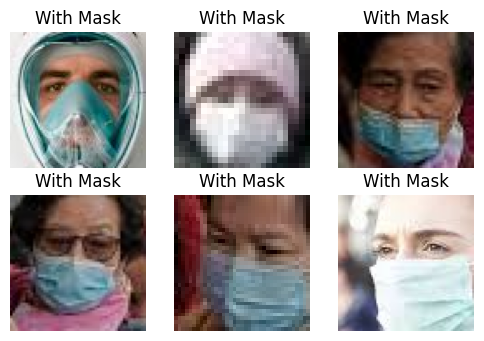

In [18]:
from os import listdir
listdir()
withmask='FaceMask/Face Mask Dataset/Train/WithMask'
train_images_NC=listdir(withmask)
plt.figure(figsize=(6,6))
for i in range(6):
 plt.subplot(3,3,i+1)
 plt.imshow(plt.imread(os.path.join(withmask,train_images_NC[i])),cmap='gray')
 plt.title('With Mask')
 plt.axis('off')
plt.show()

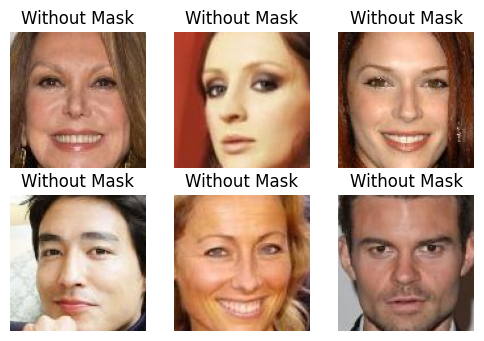

In [19]:
from os import listdir
listdir()
withoutmask='FaceMask/Face Mask Dataset/Train/WithoutMask'
train_images_NC=listdir(withoutmask)
plt.figure(figsize=(6,6))
for i in range(6):
 plt.subplot(3,3,i+1)
 plt.imshow(plt.imread(os.path.join(withoutmask,train_images_NC[i])),cmap='gray')
 plt.title('Without Mask')
 plt.axis('off')
plt.show()

In [20]:
total_train_with_mask = len(os.listdir('FaceMask/Face Mask Dataset/Train/WithMask'))
total_train_without_mask = len(os.listdir('FaceMask/Face Mask Dataset/Train/WithoutMask'))
total_test_with_mask = len(os.listdir('FaceMask/Face Mask Dataset/Test/WithMask'))
total_test_without_mask = len(os.listdir('FaceMask/Face Mask Dataset/Test/WithoutMask'))
total_val_with_mask = len(os.listdir('FaceMask/Face Mask Dataset/Validation/WithMask'))
total_val_without_mask = len(os.listdir('FaceMask/Face Mask Dataset/Validation/WithoutMask'))
print("Train sets images with mask: {}".format(total_train_with_mask))
print('--------------------------------------------')
print("Train sets images without mask: {}".format(total_train_without_mask))
print('--------------------------------------------')
print("Test sets images with mask: {}".format(total_test_with_mask))
print('--------------------------------------------')
print("Test sets images without mask: {}".format(total_test_without_mask))
print('--------------------------------------------')
print("Val sets images with mask: {}".format(total_val_with_mask))
print('--------------------------------------------')
print("Val sets images without mask: {}".format(total_val_without_mask))

Train sets images with mask: 5000
--------------------------------------------
Train sets images without mask: 5000
--------------------------------------------
Test sets images with mask: 483
--------------------------------------------
Test sets images without mask: 509
--------------------------------------------
Val sets images with mask: 400
--------------------------------------------
Val sets images without mask: 400


In [21]:
train_datagen = ImageDataGenerator( horizontal_flip=True,
 shear_range=0.2,
 rescale= 1./255,
 zoom_range=0.2,)
test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_path='FaceMask/Face Mask Dataset/Train'
test_path = 'FaceMask/Face Mask Dataset/Test'
val_path = 'FaceMask/Face Mask Dataset/Validation'

In [22]:
train_set = train_datagen.flow_from_directory(
 train_path,
 target_size=(224,224),
 batch_size=32,
 shuffle = False,
 seed = 42,
 class_mode = "categorical",
 classes = ['WithoutMask','WithMask'])


test_set = test_datagen.flow_from_directory(
 test_path,
 target_size=(224,224),
 seed = 42,
 shuffle = False,
 batch_size=32,
 class_mode = "categorical",
 classes = ['WithoutMask','WithMask'])


val_set = val_datagen.flow_from_directory(
 val_path,
 target_size=(224,224),
 seed = 42,
 shuffle = False,
 batch_size=32,
 class_mode = "categorical",
 classes = ['WithoutMask','WithMask'])

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [23]:
train_set.class_indices

{'WithoutMask': 0, 'WithMask': 1}

In [24]:
from tensorflow.keras.applications.resnet import ResNet50

resnet = ResNet50(include_top=False,
        weights='imagenet',
        input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(2,activation='softmax'))
model.summary()
model.compile(optimizer='adam',
        loss='categorical_crossentropy',
        metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 2)                 200706    
                                                                 
Total params: 23,788,418
Trainable params: 200,706
Non-trainable params: 23,587,712
_________________________________________________________________


In [25]:
resnet_history = model.fit(train_set,epochs=1,validation_data=val_set)

313/313 [==============================] - 554s 2s/step - loss: 4.8076 - accuracy: 0.5862 - val_loss: 3.2486 - val_accuracy: 0.5962


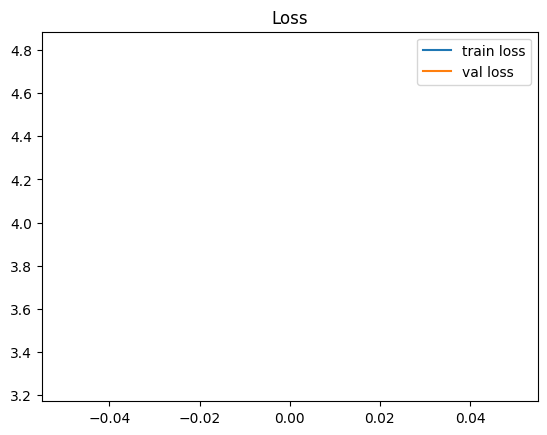

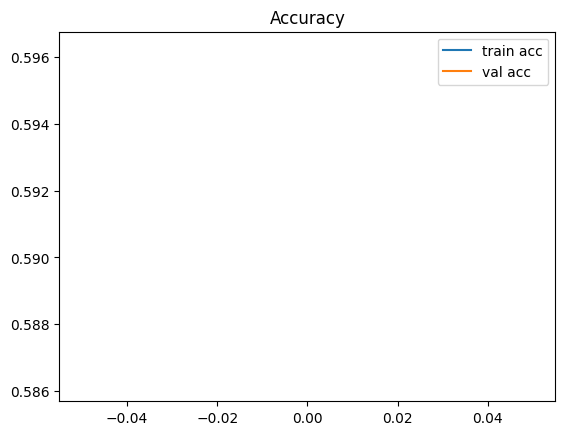

In [26]:
plt.plot(resnet_history.history['loss'], label='train loss')
plt.plot(resnet_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')


plt.plot(resnet_history.history['accuracy'], label='train acc')
plt.plot(resnet_history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

In [27]:
resnet_auc = model.evaluate(test_set)

31/31 [==============================] - 49s 2s/step - loss: 3.2091 - accuracy: 0.6018


31/31 [==============================] - 49s 2s/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

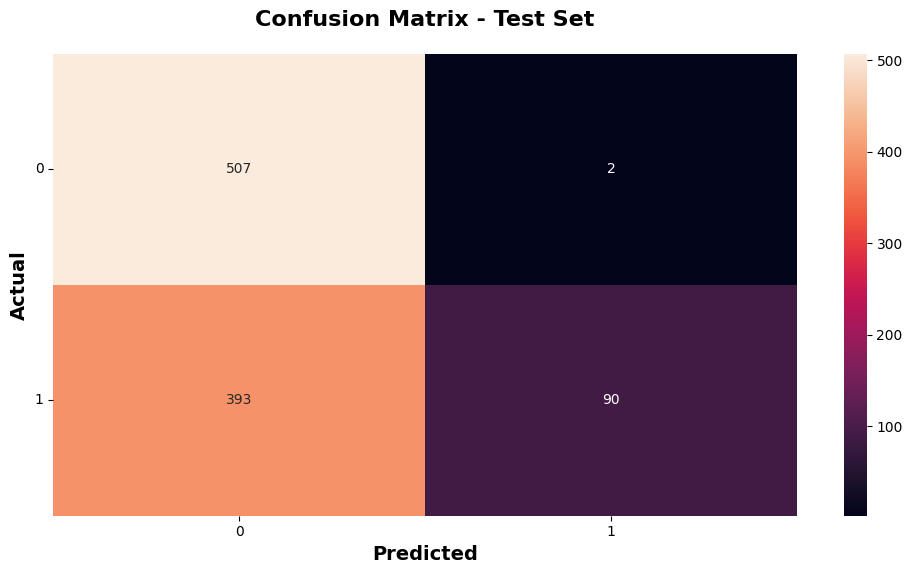

In [28]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis = 1)
test_labels = test_set.labels

plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
 test_labels,
 test_pred,
 num_classes=None,
 weights=None,
 dtype=tf.dtypes.int32,
 name=None,
),annot = True,
 fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
print (classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72       509
           1       0.98      0.19      0.31       483

    accuracy                           0.60       992
   macro avg       0.77      0.59      0.52       992
weighted avg       0.77      0.60      0.52       992

